# Cleaning and feature extraction

**Table of Contents**
- [Cleaning](#cleaning)
  - [Client communications only](#client-communications-only)
  - [VPN communications only](#vpn-communications-only)
  - [Exploring multicast communications](#exploring-multicast-communications)
  - [Final cleaning process](#final-cleaning-process)
- [Features](#features)
  - [Reconstructing packet flows](#reconstructing-packet-flows)
  - [Packet statistics](#packet-statistics)
    - [New packet feature: Inter-arrival time (ms)](#new-packet-feature-inter-arrival-time-ms)
    - [Let's see some summary statistics now](#lets-see-some-summary-statistics-now)
    - [Conditioning on direction](#conditioning-on-direction)
  - [Filters](#filters)
  - [Rolling window statistics](#rolling-window-statistics)
    - [What we can learn from our rolling windows](#what-we-can-learn-from-our-rolling-windows)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# Load in some sample streaming and non-streaming data
browsevpn = pd.read_csv('../data/unzipped/pgaddiso-novideo-vpn-linux-20201109-0.csv')
streamvpn = pd.read_csv('../data/unzipped/pgaddiso-youtube-1x-720p-vpn-linux-clean-20201102-0.csv')

## Cleaning

### Client communications only

The VPN-nonVPN dataset (ISCXVPN2016) is used by most papers in the field of encrypted network traffic classification. "We used a filter to capture only the packets with source or destination IP, the address of the local client" [(src)](https://www.unb.ca/cic/datasets/vpn.html)

In [3]:
browsevpn.head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
0,1604985856,10.0.0.236,46101,137.110.0.70,443,17,608,174,5,1,1604985856514;1604985856606;1604985856606;1604...,172;174;118;106;106;106;,1;2;1;1;1;1;
1,1604985856,10.0.0.100,10101,239.255.255.251,10101,17,64,0,1,0,1604985856731;,64;,1;
2,1604985856,10.0.0.236,51190,54.149.94.178,443,6,0,998,0,1,1604985856767;,998;,2;
3,1604985856,10.0.0.236,36578,52.13.228.162,443,6,0,145,0,1,1604985856958;,145;,2;
4,1604985856,10.0.0.236,51216,54.149.94.178,443,6,0,996,0,1,1604985856963;,996;,2;


In [4]:
streamvpn.head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
0,1604366490,2601:647:200:FF30::6362,42480,2607:F8B0:4005:1B::7,443,6,0,72,0,1,1604366490254;,72;,2;
1,1604366490,10.0.0.236,54544,137.110.0.69,443,17,244,118,2,1,1604366490255;1604366490664;1604366490688;,126;118;118;,1;1;2;
2,1604366490,10.0.0.236,60000,34.211.185.195,443,6,0,83,0,1,1604366490622;,83;,2;
3,1604366490,10.0.0.192,53112,239.255.255.250,1900,17,202,0,1,0,1604366490761;,202;,1;
4,1604366491,2601:647:200:FF30::6362,42480,2607:F8B0:4005:1B::7,443,6,0,72,0,1,1604366491143;,72;,2;


In [5]:
# How do we find the client's IP without prior knowledge? Remember, this needs
# to work on data coming from anyone.
#
# We can start by filtering out purely local communications, then see what IPs
# remain. Local communications are internal<-->internal, where an internal IP is
# one that starts with 10.0.x 0.0x, 172.16.x, 192.168.x, 169.254.x
#
# Furthermore, IPs that start with 224.x-239.x are 'multicast' IPs, and those
# starting with 255.x are 'broadcast' IPs. We can ignore these when trying to
# find what the client machine IP is.

# Why does this need to be a tuple? Because it's what startswith wants!
internal_ranges = ('10.0.', '0.0.', '172.16.', '192.168.', '169.254.')
multicast_ranges = tuple(str(i)+'.' for i in range(224,239+1))
broadcast_ranges = ('255.',)


internal_comm = lambda df: (
    (df.IP1.str.startswith(internal_ranges))
    & (df.IP2.str.startswith(internal_ranges))
)
multicast_comm = lambda df: (
    (df.IP2.str.startswith(multicast_ranges))
)
broadcast_comm = lambda df: (
    (df.IP2.str.startswith(broadcast_ranges))
)

browsevpn[
    ~internal_comm(browsevpn)
    & ~multicast_comm(browsevpn)
    & ~broadcast_comm(browsevpn)
].IP1.value_counts()

10.0.0.236    361
Name: IP1, dtype: int64

When we ignore internal communications, multicasts, and broadcasts, then we're left with only one option for the IP of the client machine (will always be in IP1 column due to how network-stats works).

In the event there are still multiple IPs here (somehow), we could use whichever IP shows up most frequently.

In [6]:
def get_client_ip(df):
    return df[
        ~internal_comm(df)
        & ~multicast_comm(df)
        & ~broadcast_comm(df)
    ].IP1.value_counts().index[0]

get_client_ip(browsevpn)

'10.0.0.236'

We can now filter to only communications containing the client IP. Note that based on how network-stats works, this will always be in the IP1 column.

In [7]:
client_comm = lambda df: (
    (df.IP1 == get_client_ip(df))
)

In [8]:
# Demo
browsevpn[client_comm(browsevpn)].head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
0,1604985856,10.0.0.236,46101,137.110.0.70,443,17,608,174,5,1,1604985856514;1604985856606;1604985856606;1604...,172;174;118;106;106;106;,1;2;1;1;1;1;
2,1604985856,10.0.0.236,51190,54.149.94.178,443,6,0,998,0,1,1604985856767;,998;,2;
3,1604985856,10.0.0.236,36578,52.13.228.162,443,6,0,145,0,1,1604985856958;,145;,2;
4,1604985856,10.0.0.236,51216,54.149.94.178,443,6,0,996,0,1,1604985856963;,996;,2;
5,1604985857,10.0.0.236,46101,137.110.0.70,443,17,290,174,2,1,1604985857749;1604985857844;1604985857845;,172;174;118;,1;2;1;


In [9]:
streamvpn[client_comm(streamvpn)].head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
1,1604366490,10.0.0.236,54544,137.110.0.69,443,17,244,118,2,1,1604366490255;1604366490664;1604366490688;,126;118;118;,1;1;2;
2,1604366490,10.0.0.236,60000,34.211.185.195,443,6,0,83,0,1,1604366490622;,83;,2;
5,1604366491,10.0.0.236,54544,137.110.0.69,443,17,3792,6813,11,10,1604366491143;1604366491183;1604366491183;1604...,126;907;118;611;118;441;118;868;118;1366;118;1...,1;2;1;1;2;2;1;1;2;2;1;2;1;2;1;2;1;1;2;1;2;
13,1604366492,10.0.0.236,54544,137.110.0.69,443,17,402,0,3,0,1604366492259;1604366492866;1604366492935;,150;126;126;,1;1;1;
14,1604366492,10.0.0.236,53784,137.110.0.69,443,6,141,141,2,2,1604366492348;1604366492370;1604366492370;1604...,89;52;89;52;,1;2;2;1;


### VPN communications only

Notice that even though we're on a VPN, there are still somehow some IPs that don't seem to be the VPN address. We can remove an communications with IP2 not equal to the most commonly seen address. **Note:** this should only be done with the explicit assumption that a VPN is in use!

In [10]:
def get_vpn_ip(df, alreadyclient=False):
    """
    If the dataframe has already been filtered to just include client
    communications then we can avoid a small amount of computation.
    """
    if not alreadyclient:
        df = df[client_comm(df)]
    return df.IP2.value_counts().index[0]

get_vpn_ip(browsevpn)

'137.110.0.70'

We can now filter to include only client communications to the VPN address.

In [11]:
vpn_comm = lambda df: (
    (df.IP2 == get_vpn_ip(df))
)

In [12]:
# Demo
browsevpn[
    vpn_comm(browsevpn)
]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
0,1604985856,10.0.0.236,46101,137.110.0.70,443,17,608,174,5,1,1604985856514;1604985856606;1604985856606;1604...,172;174;118;106;106;106;,1;2;1;1;1;1;
5,1604985857,10.0.0.236,46101,137.110.0.70,443,17,290,174,2,1,1604985857749;1604985857844;1604985857845;,172;174;118;,1;2;1;
6,1604985858,10.0.0.236,46101,137.110.0.70,443,17,6440,7649,31,40,1604985858252;1604985858252;1604985858252;1604...,189;216;189;216;189;216;189;216;193;218;126;12...,1;1;1;1;1;1;1;1;1;1;2;2;2;2;2;1;1;2;2;1;2;2;1;...
16,1604985860,10.0.0.236,46101,137.110.0.70,443,17,118,118,1,1,1604985860907;1604985860908;,118;118;,2;1;
17,1604985861,10.0.0.236,46101,137.110.0.70,443,17,118,118,1,1,1604985861383;1604985861458;,118;118;,1;2;
...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,1604986152,10.0.0.236,46101,137.110.0.70,443,17,177,490,1,3,1604986152054;1604986152054;1604986152055;1604...,138;214;177;138;,2;2;1;2;
672,1604986153,10.0.0.236,46101,137.110.0.70,443,17,138,190,1,1,1604986153346;1604986153346;,190;138;,2;1;
675,1604986154,10.0.0.236,46101,137.110.0.70,443,17,3484,3345,16,18,1604986154348;1604986154425;1604986154426;1604...,177;177;138;190;138;189;225;189;225;472;779;14...,1;2;1;2;1;1;1;1;1;1;1;1;2;2;2;2;1;2;2;2;2;2;1;...
677,1604986155,10.0.0.236,46101,137.110.0.70,443,17,315,177,2,1,1604986155348;1604986155425;1604986155426;,177;177;138;,1;2;1;


### Exploring multicast communications

Supposedly, multicast communications are "used for streaming media and other network applications" [(src)](https://en.wikipedia.org/wiki/IP_multicast) Therefore, it's possible that the presense of multicast communications could actually suggest streaming is occurring, in which case we wouldn't want to remove it!

Let's examine this possibility -- do our multicast communications look different between browsing with a VPN versus streaming with a VPN?

In [13]:
bm = browsevpn[multicast_comm(browsevpn)]
bm.head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
1,1604985856,10.0.0.100,10101,239.255.255.251,10101,17,64,0,1,0,1604985856731;,64;,1;
7,1604985858,10.0.0.190,60000,239.255.255.250,1900,17,8730,0,24,0,1604985858427;1604985858430;1604985858434;1604...,337;346;383;385;339;348;385;387;337;346;383;38...,1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
9,1604985859,10.0.0.158,5353,224.0.0.251,5353,17,202,0,1,0,1604985859079;,202;,1;
11,1604985859,10.0.0.17,5353,224.0.0.251,5353,17,178,0,1,0,1604985859877;,178;,1;
14,1604985860,10.0.0.197,0,224.0.0.251,0,2,32,0,1,0,1604985860821;,32;,1;


In [14]:
sm = streamvpn[multicast_comm(streamvpn)]
sm.head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
3,1604366490,10.0.0.192,53112,239.255.255.250,1900,17,202,0,1,0,1604366490761;,202;,1;
9,1604366491,10.0.0.192,53112,239.255.255.250,1900,17,202,0,1,0,1604366491761;,202;,1;
10,1604366491,10.0.0.191,5353,224.0.0.251,5353,17,578,0,1,0,1604366491868;,578;,1;
22,1604366494,10.0.0.100,10101,239.255.255.251,10101,17,64,0,1,0,1604366494035;,64;,1;
51,1604366502,10.0.0.64,5353,224.0.0.251,5353,17,837,0,3,0,1604366502586;1604366502587;1604366502946;,167;393;277;,1;1;1;


In [15]:
bm.filter(like='->').describe().round(2)

,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts
count,237.00,237.0,237.00,237.0
mean,191.41,0.0,1.31,0.0
std,800.41,0.0,2.19,0.0
min,28.00,0.0,1.00,0.0
25%,32.00,0.0,1.00,0.0
50%,64.00,0.0,1.00,0.0
75%,175.00,0.0,1.00,0.0
max,8730.00,0.0,24.00,0.0


In [16]:
sm.filter(like='->').describe().round(2)

,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts
count,180.00,180.0,180.00,180.0
mean,211.18,0.0,1.31,0.0
std,356.11,0.0,1.18,0.0
min,28.00,0.0,1.00,0.0
25%,56.00,0.0,1.00,0.0
50%,112.00,0.0,1.00,0.0
75%,188.50,0.0,1.00,0.0
max,2902.00,0.0,8.00,0.0


Hmmmmm, nothing definitive jumps out. Browsing actually seemed to have *more* multicast activity. **Note:** It's entirely possible that 1) we are capturing streaming behavior of *other* devices which utilize IP multicast, and 2) I am not knowledgeable about multicast.

Let's keep it filtered out.

### Final cleaning process

Isolate the client<-->VPN communications.

In [17]:
b = browsevpn[vpn_comm(browsevpn)]
s = streamvpn[vpn_comm(streamvpn)]

## Features

As summarized in [A Survey on Encrypted Traffic Classification](https://doi.org/10.1007/978-3-662-45670-5_8) by Zigang Cao et al., the majority of statistics-based traffic classification models use both 'packet level' and 'flow level' measurements. Packet measurements boil down to inter-packet arrival times, packet size and directions. Flow measurements include the number of packets sent to/from a source, ratios in directions and sizes, and other statistics built from packet measurements between a specified pair of IPs.

These features are consistent with those discussed in numerous papers, and are the features we will primarily focus on extracting here.

In [18]:
s.head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
1,1604366490,10.0.0.236,54544,137.110.0.69,443,17,244,118,2,1,1604366490255;1604366490664;1604366490688;,126;118;118;,1;1;2;
5,1604366491,10.0.0.236,54544,137.110.0.69,443,17,3792,6813,11,10,1604366491143;1604366491183;1604366491183;1604...,126;907;118;611;118;441;118;868;118;1366;118;1...,1;2;1;1;2;2;1;1;2;2;1;2;1;2;1;2;1;1;2;1;2;
13,1604366492,10.0.0.236,54544,137.110.0.69,443,17,402,0,3,0,1604366492259;1604366492866;1604366492935;,150;126;126;,1;1;1;
14,1604366492,10.0.0.236,53784,137.110.0.69,443,6,141,141,2,2,1604366492348;1604366492370;1604366492370;1604...,89;52;89;52;,1;2;2;1;
18,1604366493,10.0.0.236,54544,137.110.0.69,443,17,382,106,3,1,1604366493227;1604366493228;1604366493511;1604...,106;106;126;150;,2;1;1;1;


### Reconstructing packet flows

It's worth noting that network-stats essentially generates some `sum` and `count` statistics in 1 second bins. We want the ability to generate additional flow statistics and change bin sizes, so we will re-construct the per-packet flows from network-stat's extended output.

In [19]:
def packet_flows(df):
    
    UNIT = 'ms'
    
    # Each of the extended columns contains a semicolon separated (and trailing)
    # string of measurements.
    #
    # We can extract these measurements such that each second (row) contains
    # a native python list of measurements. The `sum` in this setting simply
    # aggregates all lists down each column.
    lists = (
        df.filter(like='packet')
        .apply(lambda ser: ser.str.split(';').str[:-1])
        .sum()
    )
    
    frame = pd.DataFrame({
        'ptime': lists.packet_times,
        'psize': lists.packet_sizes,
        'pdir' : lists.packet_dirs
    }).astype(int)
    
    # Need to sort by arrival to ensure monotonicity -- will be useful for
    # rolling windows and inter-arrival times.
    frame = frame.sort_values('ptime')
    
    # Replace timestamp with a delta from the first packet
    frame['ptime'] = pd.to_timedelta(frame.ptime - frame.ptime[0], UNIT)
    frame = frame.set_index('ptime')
    
    # Hold your horses -- this is a new feature, not a reconstruction. Save it
    # for later.
    # frame['msdelta'] = frame.ptime.diff()
    
    return frame

packet_flows(s)

,psize,pdir
ptime,,
0 days 00:00:00,126,1
0 days 00:00:00.409000,118,1
0 days 00:00:00.433000,118,2
0 days 00:00:00.888000,126,1
0 days 00:00:00.928000,907,2
...,...,...
0 days 00:05:00.720000,189,1
0 days 00:05:00.720000,216,1
0 days 00:05:00.720000,189,1


### Packet statistics

Now that we have the reconstructed packet flows, we can generate packet statistics with ease.

**Note:** All of these dataset 'chunks' have the same duration of five minutes (300 seconds). This allows for count and sum to be valid statistics for size. We'll see in a bit an alternative though.

In [20]:
# A hackish feature 'pipeline'
def features(df, *funcs):
    for func in funcs:
        df = func(df)
    return df

#### New packet feature: Inter-arrival time (ms)

In [21]:
def interarrival(df):
    # Converting to numeric for better stability with statistical functions
    df['msdelta'] = df.index.to_series().diff().dt.total_seconds() * 1000
    return df

interarrival(packet_flows(b))

,psize,pdir,msdelta
ptime,,,
0 days 00:00:00,172,1,NaN
0 days 00:00:00.092000,174,2,92.0
0 days 00:00:00.092000,118,1,0.0
0 days 00:00:00.253000,106,1,161.0
0 days 00:00:00.444000,106,1,191.0
...,...,...,...
0 days 00:05:00.332000,214,2,77.0
0 days 00:05:00.332000,138,2,0.0
0 days 00:05:00.333000,177,1,1.0


#### Let's see some summary statistics now

In [22]:
desired_aggs = ['count', 'sum','mean', 'std', 'median', 'min', 'max']
feats = [packet_flows, interarrival]

In [23]:
features(b, *feats).agg(desired_aggs).round(2)

,psize,pdir,msdelta
count,13464.00,13464.00,13463.00
sum,6643243.00,20355.00,300415.00
mean,493.41,1.51,22.31
std,531.20,0.50,138.65
median,163.00,2.00,0.00
min,52.00,1.00,0.00
max,1366.00,2.00,4529.00


In [24]:
features(s, *feats).agg(desired_aggs).round(2)

,psize,pdir,msdelta
count,30273.00,30273.00,30272.00
sum,28041937.00,51333.00,300730.00
mean,926.30,1.70,9.93
std,566.52,0.46,104.96
median,1346.00,2.00,0.00
min,40.00,1.00,0.00
max,1500.00,2.00,4470.00


#### Conditioning on direction

Some features should be computed separate on each group! For example, the time deltas may be interesting to look at after grouping... We can do so by specifying an `apply` with another feature pipeline after the `groupby`. A direction of '1' refers to an uploaded packet, whereas '2' refers to a downloaded packet.

In [25]:
(
    features(b, packet_flows)
    .groupby('pdir')
    .apply(features, interarrival)
    .groupby('pdir')
    .agg(desired_aggs).round(2)
).T

pdir                     1           2
psize   count      6573.00     6891.00
        sum     1363659.00  5279584.00
        mean        207.46      766.16
        std         242.51      585.54
        median      130.00      647.00
        min          52.00       52.00
        max        1366.00     1366.00
msdelta count      6572.00     6890.00
        sum      300408.00   300323.00
        mean         45.71       43.59
        std         200.78      221.75
        median        0.00        0.00
        min           0.00        0.00
        max        4529.00     4551.00

### Filters

Often, filters may be useful -- these differ from cleaning since they happen after some feature engineering has already occurred. One useful filter would be to only look at packets which were uploaded (pdir == 1) or only which were downloaded (pdir == 2). I might refer to these as sending and receiving packets.

Filters can be applied using a functional `loc`.

In [26]:
upload_pkts = lambda df: (
    df.pdir == 1
)
download_pkts = lambda df: (
    df.pdir == 2
)

def filters(df, *funcs):
    for func in funcs:
        df = df[func(df)]
    return df

In [27]:
fb = features(b, *feats)
fs = features(s, *feats)

ub = filters(fb, upload_pkts)
db = filters(fb, download_pkts)
us = filters(fs, upload_pkts)
ds = filters(fs, download_pkts)

### Rolling window statistics

Instead of working with essentially one bin of 300s in length, we can create smaller bins. This is what network-stats does. But, we can one-up this by using a rolling windows instead of non-overlapping bins. This should allow us to demonstrate smoother trends with larger window sizes.

In [28]:
ds.rolling('10s').agg(['mean', 'min', 'max']).iloc[600:603]

psize               pdir             msdelta  \
                               mean   min     max mean  min  max      mean   
ptime                                                                        
0 days 00:00:26.418000  1100.680297  52.0  1500.0  2.0  2.0  2.0  6.269517   
0 days 00:00:26.423000  1098.871985  52.0  1500.0  2.0  2.0  2.0  6.265306   
0 days 00:00:26.515000  1098.836735  52.0  1500.0  2.0  2.0  2.0  4.903525   

                                    
                        min    max  
ptime                               
0 days 00:00:26.418000  0.0  826.0  
0 days 00:00:26.423000  0.0  826.0  
0 days 00:00:26.515000  0.0  648.0

In [29]:
def compare_rolling(browse, stream, col, seconds, stat='mean', filts=[],
                    ax=None, title=None, xlabel=None, ylabel=None, legend=True):
    """
    Draws an overlaid plot of rolling window statstics for browsing data versus
    streaming data.
    
    Parameters
    ----------
    browse, stream : DataFrame
        Tables for browsing and streaming data, respectively.
    col : str
        Name of column to draw.
    seconds : int
        The window size.
    stat : {'mean', 'count', callable}
        The function to apply to each window.
    filters : list of callable
        Filters to be applied to each frame before calculating windows.
        
    Return
    ------
    matplotlib.axes
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    
    def plot_rolling(df, col, label=None):
    
        rolled = df.rolling(str(seconds)+'s')

        if stat == 'mean':
            frame = rolled.mean()
        elif stat == 'count':
            frame = rolled.count()
        elif stat == 'std':
            frame = rolled.std()
        else:
            frame = rolled.apply(stat)

        ax.plot(
            frame.index.total_seconds(),
            frame[col],
            label=label
        )
    
    b_filt = filters(browse, *filts)
    s_filt = filters(stream, *filts)
    
    plot_rolling(b_filt, col, 'Browsing')
    plot_rolling(s_filt, col, 'Streaming')
    
    # Shade region where rolling window is effective
    maxseconds = min(b_filt.index[-1], s_filt.index[-1]).total_seconds()
    ax.axvspan(seconds, max(seconds, maxseconds-seconds), color='#0f01')
    
    # Title and labels
    ax.set_title(title or f"Rolling {stat} {col}, window={seconds}s")
    ax.set_xlabel(xlabel or 'Time delta from first packet (seconds)')
    ax.set_ylabel(ylabel or f"{stat} {col}")
    
    if legend:
        ax.legend()

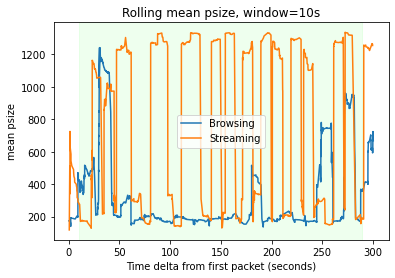

In [30]:
compare_rolling(db, ds, 'psize', 10)

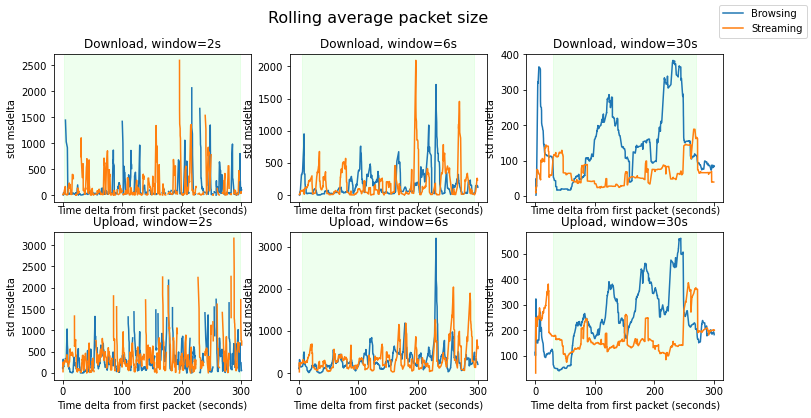

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=False)

seconds = [2, 6, 30]
col = 'msdelta'
stat = 'std'

for i, ax in enumerate(axes[0]):
    compare_rolling(fb, fs, col, seconds[i], stat, [download_pkts],
                    ax=ax, legend=False, title=f"Download, window={seconds[i]}s")
for i, ax in enumerate(axes[1]):
    compare_rolling(fb, fs, col, seconds[i], stat, [upload_pkts],
                   ax=ax, legend=False, title=f"Upload, window={seconds[i]}s")

fig.legend(['Browsing', 'Streaming'])
fig.suptitle('Rolling average packet size', fontsize=16);

- Differences in packet size are most effective when looking at download packets.
- Differences start to show up even at small windows (1s) but become more *consistent* across the entire time range when the window size is slightly larger (4s+)
- Differences at small windows is in the frequency and height of 'spikes'
- At large windows (30s+) spikes start to become smoothed out, and the general trend of Streaming packets simply being larger than Browsing packets emerges.
- Differences are not perfectly consistent, namely Browsing behavior at <50 time delta has higher magnitude spikes than Streaming!

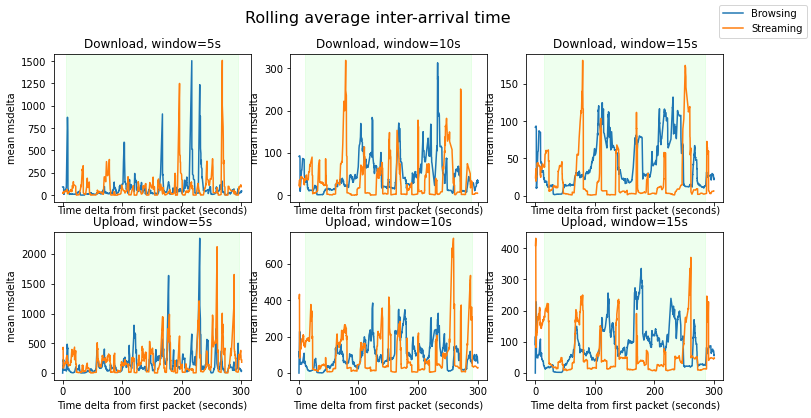

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=False)

seconds = [5, 10, 15]
col = 'msdelta'
stat = 'mean'

for i, ax in enumerate(axes[0]):
    compare_rolling(fb, fs, col, seconds[i], stat, [download_pkts],
                    ax=ax, legend=False, title=f"Download, window={seconds[i]}s")
for i, ax in enumerate(axes[1]):
    compare_rolling(fb, fs, col, seconds[i], stat, [upload_pkts],
                   ax=ax, legend=False, title=f"Upload, window={seconds[i]}s")

fig.legend(['Browsing', 'Streaming'])
fig.suptitle('Rolling average inter-arrival time', fontsize=16);

- Both download and upload inter-arrival times show periodicity with Streaming, versus sporadicity with Browsing. Download start to show more differences in magnitude, though.
- At medium window sizes (10s) differences start to emerge pertaining to the regularity of Streaming deltas, as opposed to sporadicity of Browsing deltas.
- As the window size continues to increase (15s+) it becomes visually apparent that Streaming exhibits significantly more deltas near zero.

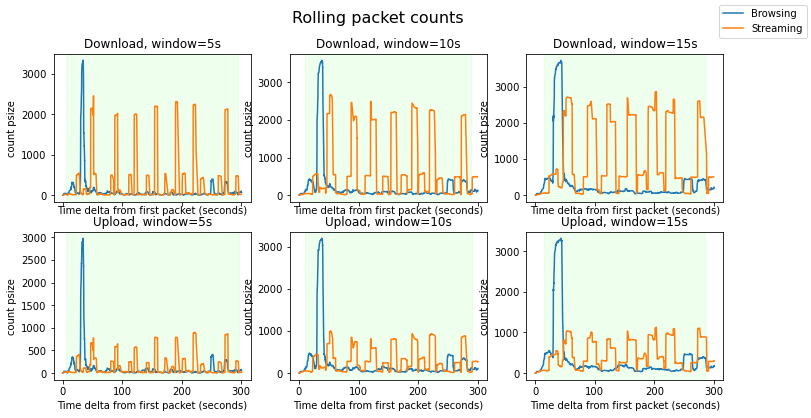

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=False)

seconds = [5, 10, 15]
col = 'psize'
stat = 'count'

for i, ax in enumerate(axes[0]):
    compare_rolling(fb, fs, col, seconds[i], stat, [download_pkts],
                    ax=ax, legend=False, title=f"Download, window={seconds[i]}s")
for i, ax in enumerate(axes[1]):
    compare_rolling(fb, fs, col, seconds[i], stat, [upload_pkts],
                   ax=ax, legend=False, title=f"Upload, window={seconds[i]}s")

fig.legend(['Browsing', 'Streaming'])
fig.suptitle('Rolling packet counts', fontsize=16);

- Discovering periodicity vs sporadicity lends itself to a self-attention model.

#### What we can learn from our rolling windows

Our intention is to:
- Find a window size that exhibits differences between Browsing and Streaming which are *consistent* across the timeline.
- Find a bin width capable of capturing those consistent differences
    - This is only necessary under the assumption that we want to ultimately use data of fixed lengths as input to our model.

It's worth noting that I'm unfamiliar with time-series models -- chances are we don't need to make those bins, we can just keep feeding in timeseries data until the model is confident enough to make a classification!

```










```

# MATPLOTLIB BUG REPORT

These lines do not have equal domains, but appear so on the graph.

Above I am struggling to get equal domains to appear so -- one appears squished.

The heck is going on here matplotlib?

In [319]:
df1 = pd.DataFrame({
    'delta': pd.to_timedelta([1, 2, 3, 5, 10], 's'),
    'value': [4, 4, 3, 3, 2]
}).set_index('delta')
df2 = pd.DataFrame({
    'delta': pd.to_timedelta([1,2,2,6,8], 's'),
    'value': [1,2,3,4,3]
}).set_index('delta')

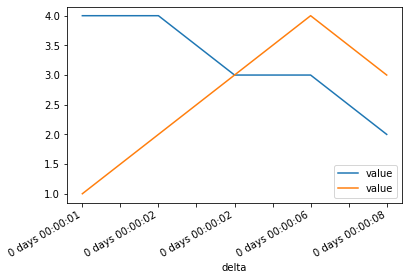

In [320]:
ax = df1.plot()
df2.plot(ax=ax)
